# Análisis de cargas en HCN

Instalamos ASE y GPAW
https://wiki.fysik.dtu.dk/ase/install.html
https://wiki.fysik.dtu.dk/gpaw/install.html


In [ ]:
#(Instalación en terminal o Colab)
%%capture
!apt install python3-mpi4py cython3 libxc-dev gpaw-data
!pip -q install gpaw pymatgen

Importamos bibliotecas

In [ ]:
from ase.build import molecule
from ase.io import write
from ase.units import Bohr
from gpaw import GPAW
from gpaw.analyse.hirshfeld import HirshfeldPartitioning
import numpy as np
import time
from pylab import *

## Convergencia de resolución de mallado

In [ ]:
hs=[]

a=np.arange(0.09,0.4,0.07)

for hi in np.sort(a)[::-1]: #eV
    atoms = molecule ('HCN')
    atoms.center(vacuum = 3)
    atoms.calc = GPAW(h = hi, txt = 'hcn.txt')

    t0 = time.time()
    energy = atoms.get_potential_energy()
    t1 = time.time()
    Etime = t1-t0
    hs.append([hi,energy])
    print(hi, energy, Etime)


0.37 6.552207926075329 5.487196445465088
0.30000000000000004 -17.552860386515555 7.910893440246582
0.23 -20.859763042195127 12.00173306465149
0.16 -20.78823666191357 15.016490936279297
0.09 -20.789649125297505 94.44020438194275


In [ ]:
hs = np.array(hs)

Text(0, 0.5, 'Energía [eV]')

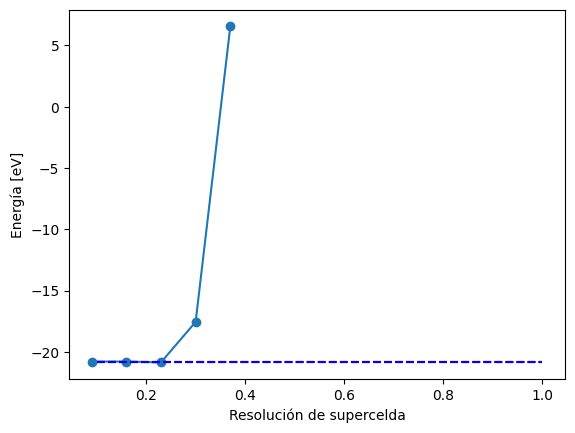

In [ ]:
#| label: fig-conv-hs
#| fig-cap: >
#|  Plot de convergencia
plt.plot(hs[:,0],hs[:,1],'o-')
plt.plot([0.1,1],[hs[-1,1],hs[-1,1]],'r--')
plt.plot([0.1,1],[hs[-1,1]+0.001,hs[-1,1]+0.001],'b--')
plt.plot([0.1,1],[hs[-1,1]-0.001,hs[-1,1]-0.001],'b--')

plt.xlabel('Resolución de supercelda')
plt.ylabel('Energía [eV]')

In [ ]:
hConv = None
delta = 1e-1 #Parámetro de convergencia

for i in range(len(hs)):
  g = np.gradient(hs,axis=0)
  if abs(g[i][1]) < delta:
    hConv = hs[i][0]
    print('El espaciado de la malla para la convergencia es',hConv)
    break

El espaciado de la malla para la convergencia es 0.16


## Convergencia del tamaño de la supercelda

In [ ]:
vac=[]

for supercell in np.arange(3,13): #eV
    atoms = molecule ('HCN')
    atoms.center(vacuum = supercell)
    atoms.calc = GPAW(h = hConv, txt = f'hcn-{supercell:d}.txt')

    t0 = time.time()
    energy = atoms.get_potential_energy()
    t1 = time.time()
    Etime = t1-t0
    vac.append([supercell,energy])
    print(supercell, energy, Etime)

3 -20.78823666191357 12.023082733154297
4 -20.81830502357433 25.096040725708008
5 -20.811299818567306 42.868160009384155
6 -20.80775261527836 69.19943809509277
7 -20.805840454589784 106.19662666320801
8 -20.804225238824188 140.49988293647766
9 -20.80317808391598 204.4915623664856
10 -20.80236882889115 268.70350313186646
11 -20.801889423630215 362.48192596435547
12 -20.801920350966036 510.1052327156067


In [ ]:
vac = np.array(vac)

Text(0, 0.5, 'Energía [eV]')

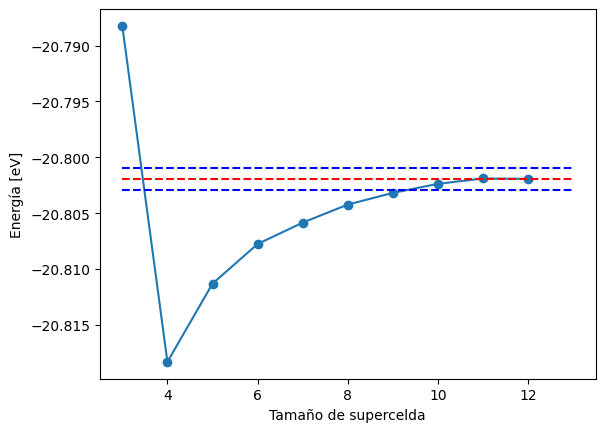

In [ ]:
plt.plot(vac[:,0],vac[:,1],'o-')
plt.plot([3,13],[vac[-1,1],vac[-1,1]],'r--')
plt.plot([3,13],[vac[-1,1]+0.001,vac[-1,1]+0.001],'b--')
plt.plot([3,13],[vac[-1,1]-0.001,vac[-1,1]-0.001],'b--')

plt.xlabel('Tamaño de supercelda')
plt.ylabel('Energía [eV]')

## Calculo de energía y cargas con parámetros convergidos

In [ ]:
SCellConv = None
delta = 3e-4 #Parámetro de convergencia

for i in range(len(vac)):
  g = np.gradient(vac,axis=0)
  #print(g)
  if abs(g[i][1]) < delta:
    SCellConv = vac[i][0]
    print('El tamaño de la supercelda para la convergencia es',SCellConv)
    break

El tamaño de la supercelda para la convergencia es 11.0


In [ ]:
atoms = molecule('HCN')
atoms.center(vacuum=SCellConv)
atoms.calc = GPAW(h=hConv, txt='hcn.txt')
atoms.get_potential_energy()

-20.801889423630215

In [ ]:
# Cargas de Hirshfeld
hf = HirshfeldPartitioning(atoms.calc)
for atom, charge in zip(atoms, hf.get_charges()):
    atom.charge = charge
    print (charge)

atoms.copy().write('Hirshfeld.traj')

# Crear Densidad electrónica y escribir
rho = atoms.calc.get_all_electron_density(gridrefinement=4)
write('density.cube', atoms, data=rho * Bohr**3)

0.04359468562323254
-0.17510036425308595
0.13217884839219185


Si leemos el documento density.cube en VESTA, obsarevamos la siguiente imagen: